# Evaluate fit between semantic embeddings and real-world object relationships

## Setup notebook

### Import libraries`

In [938]:
# general utilities
import os
import json
import random
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from itertools import combinations
from scipy import stats

# spatial distance manipulations
import scipy.spatial as sps
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance

# plotting
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# semantic embdedding
from gensim.models import KeyedVectors
from utils.utils import *

# sns.set_style("whitegrid")
# sns.set_context('talk')
sns.set_theme(style='dark', context='talk', rc={"axes.spines.right": False, "axes.spines.top": False})

### Set up paths

In [254]:
# set up paths
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir, 'data')
util_dir = os.path.join(proj_dir, 'utils')
analysis_dir = os.path.join(proj_dir, 'analysis')

### Read in data

In [255]:
# read metadata
df = pd.read_csv('data/metadata.csv')
df['labels'] = df.labels.apply(eval)
df['instances'] = df.instances.apply(eval)

# read in image, depth, label, and instance images as memory maps
imgmat = np.memmap(os.path.join(data_dir, 'image_arr.npy'), dtype='uint8', mode='r', 
                   offset=128, shape=(1449,480,640,3))
depmat = np.memmap(os.path.join(data_dir, 'depth_arr.npy'), dtype='<f4', mode='r', 
                   offset=128, shape=(1449,480,640))
labmat = np.memmap(os.path.join(data_dir, 'label_arr.npy'), dtype='uint16', mode='r', 
                  offset=128, shape=(1449,480,640))
instmat = np.memmap(os.path.join(data_dir, 'instance_arr.npy'), dtype='uint8', mode='r', 
                  offset=128, shape=(1449,480,640))

# read in objects
object_df = pd.read_csv(os.path.join(data_dir, 'spatial_exemplars.csv'))

# read in semantic objects
semantic_object_df = pd.read_csv(os.path.join(data_dir, 'semantic_spatial_exemplars.csv'))

# read dictionary mapping
with open(os.path.join(data_dir, 'namesToIds.json')) as json_file:
    namesToIds = json.load(json_file)
namesToIds['unlabeled'] = 0
idsToNames = {v: k for k, v in namesToIds.items()}

# import semantic embedding model
ft_300 = KeyedVectors.load(
    'models/fasttext-wiki-news-subwords-300.kv', mmap='r')

#### Clean up dataframes

In [256]:
def within_group_transform(dataframe, var, func):
    aggs = dataframe.groupby('image_index')[var].apply(lambda x: func(x))
    aggs = aggs.repeat(dataframe.groupby('image_index').count().exemplar.values).values
    return aggs

In [257]:
# clean up used labels
unwanted_labels = ['unknown', 'wall', 'ceiling', 'floor', 'door', 'window', 'person', 'unlabeled']
errs = {'bookrack':'bookshelf', 'ladel': 'ladle', 'watermellon': 'watermelon', 
        'collander': 'colander', 'desser':'dresser', 'toyhouse': 'toy house', 
        'flipboard': 'flip board', 'nailclipper': 'nail clipper', 
        'fruitplate': 'fruit plate', 'walkietalkie': 'walkie talkie', 
        'mailshelf': 'mail shelf', 'kichen towel': 'kitchen towel', 'vasoline': 'vaseline',
        'storage shelvesbooks': 'bookshelf', 'door facing trimreflection': 'door reflection',
        'doorreflection': 'door reflection', 'light switchreflection': 'light switch reflection'}
unerrs = {v: k for k, v in errs.items()}

df['instances_clean'] = df.instances.apply(lambda x: [inst.split('_')[0] for inst in x])
df['instances_clean'] = df.instances_clean.apply(lambda x: [inst for inst in x if inst not in unwanted_labels])
df['labels'] = df.labels.apply(lambda x: [lab for lab in x if lab not in unwanted_labels])
df['labels'] = df.labels.apply(lambda x: [errs[lab] if lab in errs.keys() else lab for lab in x])
df['instances_clean'] = df.instances_clean.apply(lambda x: [errs[lab] if lab in errs.keys() else lab for lab in x])

object_df['label'] = object_df.label.replace(errs)
object_df = object_df[~object_df.label.isin(unwanted_labels)]

kept_indices = semantic_object_df.image_index.unique()
object_df = object_df[object_df.image_index.isin(kept_indices)]
object_df = object_df.reset_index(drop=True)
semantic_object_df = semantic_object_df.groupby(['image_index', 'exemplar']).first().reset_index()
object_df['exemplar'] = object_df.label.replace(unerrs).map(namesToIds) * 100 + object_df.instance

semantic_object_df = semantic_object_df.sort_values(by=['image_index', 'exemplar']).reset_index(drop=True)
object_df = object_df.sort_values(by=['image_index', 'exemplar']).reset_index(drop=True)

object_df['instance'] = object_df.groupby(['image_index','label']).cumcount()+1
object_df['exemplar'] = object_df.label.replace(unerrs).map(namesToIds) * 100 + object_df.instance


# rearrange columns
semantic_object_df = semantic_object_df[['image_index', 'exemplar', 'label', 'instance', 'x', 'y', 'z']]
object_df = object_df[['image_index', 'exemplar', 'label', 'instance', 'x_dist', 'y_dist', 'depth', 'x', 'y']]

min_points = semantic_object_df.groupby('image_index')[['x','y','z']].min().min(axis=1)
min_points = min_points.repeat(semantic_object_df.groupby('image_index').count().exemplar.values).values
semantic_object_df[['x', 'y', 'z']] = semantic_object_df[['x', 'y', 'z']].subtract(min_points, axis=0)

object_df['x_dist'] = object_df.x_dist / within_group_transform(object_df, 'x_dist', max)
object_df['y_dist'] = object_df.y_dist / within_group_transform(object_df, 'y_dist', max)
object_df['depth'] = object_df.depth / within_group_transform(object_df, 'depth', max)

In [258]:
semantic_object_df.head()

,image_index,exemplar,label,instance,x,y,z
0,0,101,book,1,0.500767,0.500767,0.500767
1,0,201,bottle,1,0.996643,0.500767,0.500767
2,0,301,cabinet,1,0.741480,0.584033,0.000000
3,0,302,cabinet,2,0.741480,0.737501,0.051703
4,0,501,chair,1,0.682055,0.310570,0.127221


In [259]:
object_df.head()

,image_index,exemplar,label,instance,x_dist,y_dist,depth,x,y
0,0,101,book,1,0.492611,1.000000,0.871315,300,473
1,0,201,bottle,1,0.072250,0.621564,0.706228,44,294
2,0,301,cabinet,1,0.303777,0.826638,0.866894,185,391
3,0,302,cabinet,2,0.131363,0.315011,0.771551,80,149
4,0,501,chair,1,0.963875,0.934461,0.603411,587,442


## Visualize coordinates

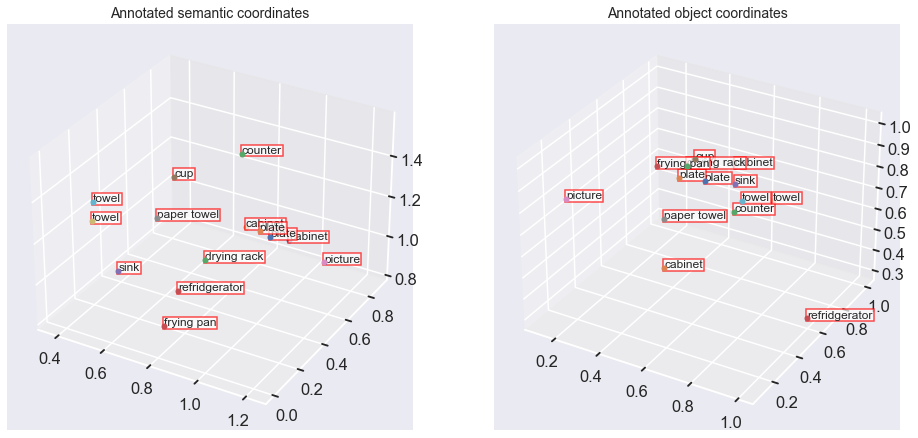

In [982]:
# show result for a random image
# 57, 1118,  536,  519, 1231,  922,  659,  924, 1192,  687,  477, 644
samp_idx = np.random.choice(semantic_object_df.image_index.unique())
samp_df_1 = semantic_object_df[semantic_object_df.image_index == samp_idx]
samp_df_2 = object_df[object_df.image_index == samp_idx]

# plot annotated labels on top of image
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

for idx, row in samp_df_1.iterrows():
    ax.scatter(row.x, row.y, row.z)
    ax.text(row.x, row.y, row.z, row.label, fontsize=12,
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=1))
ax.set_title('Annotated semantic coordinates', fontsize=14)

ax = fig.add_subplot(1, 2, 2, projection='3d')
for idx, row in samp_df_2.iterrows():
    ax.scatter(row.x_dist, row.y_dist, row.depth)
    ax.text(row.x_dist, row.y_dist, row.depth, row.label, fontsize=12,
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=1))
ax.set_title('Annotated object coordinates', fontsize=14)

plt.show()

In [261]:
# min dist comparison. conceptually flawed
# min_dists_mean = []
# rand_dists_mean = []
# for i in range(1449):
#     samp_df_1 = semantic_object_df[semantic_object_df.image_index == i]
#     samp_df_2 = object_df[object_df.image_index == i]

#     min_dists = []
#     rand_dists = []
#     for idx, row in samp_df_1.iterrows():
#         subs = samp_df_2[samp_df_2.label == row.label]
#         min_dist = np.square(subs[['x_dist', 'y_dist', 'depth']].values
#                              - row[['x', 'y', 'z']].values).sum(axis=1).min() ** 0.5

#         rand_loc = samp_df_2.sample(subs.shape[0])[['x_dist', 'y_dist', 'depth']].values
#         rand_dist = np.square(rand_loc - row[['x', 'y', 'z']].values).sum(axis=1).min() ** 0.5
#         min_dists.append(min_dist)
#         rand_dists.append(rand_dist)
#     min_dists_mean.append(np.mean(min_dists))
#     rand_dists_mean.append(np.mean(rand_dists))

## Do the distance matrices correlate well?

In [215]:
def semantic_dists(df):
    df_instances = df.label + '_' + df.instance.astype(str)
    # initialize nxn dissimilarity matrix, where each entry is a object label
    label_sims = pd.DataFrame(index=df.label, columns=df.label)

    # compute word2vec similarity for every pair of objects
    for word1, word2 in combinations(df.label.values, 2):
        word1_w = list(filter(None, word1.split(' ')))
        word2_w = list(filter(None, word2.split(' ')))
        label_sims.at[word1, word2] = ft_300.n_similarity(word1_w, word2_w)
        label_sims.at[word2, word1] = ft_300.n_similarity(word2_w, word1_w)
    

    label_sims = label_sims.fillna(1)
    label_sims = (1 / label_sims) - 1
    label_sims = label_sims / label_sims.values.max()
    
    return label_sims.values

In [281]:
sem_corrs = []
rand_corrs = []
sem_unreal_corrs = []
sem_spcorrs = []
rand_spcorrs = []
sem_unreal_spcorrs = []

for i in tqdm(range(1449)):
    samp_df_1 = semantic_object_df[semantic_object_df.image_index == i]
    samp_df_2 = object_df[object_df.image_index == i]
    
    if samp_df_1.shape[0] == 0:
        continue

    sem_euc = euclidean_distances(samp_df_1[['x', 'y', 'z']])
    obj_euc = euclidean_distances(samp_df_2[['x_dist', 'y_dist', 'depth']])
    rand_euc = euclidean_distances(np.random.random((obj_euc.shape[0], 3)))
    sem_unreal_dist = semantic_dists(samp_df_1)

    sem_corr = np.corrcoef(obj_euc.flatten(), sem_euc.flatten())
    rand_corr = np.corrcoef(obj_euc.flatten(), rand_euc.flatten())
    sem_unreal_corr = np.corrcoef(obj_euc.flatten(), sem_unreal_dist.flatten())
    
    sem_spcorr = stats.spearmanr(obj_euc.flatten(), sem_euc.flatten()).correlation
    rand_spcorr = stats.spearmanr(obj_euc.flatten(), rand_euc.flatten()).correlation
    sem_unreal_spcorr = stats.spearmanr(obj_euc.flatten(), sem_unreal_dist.flatten()).correlation
    
    sem_corrs.append(sem_corr[0,1])
    rand_corrs.append(rand_corr[0,1])
    sem_unreal_corrs.append(sem_unreal_corr[0,1])

    sem_spcorrs.append(sem_spcorr)
    rand_spcorrs.append(rand_spcorr)
    sem_unreal_spcorrs.append(sem_unreal_spcorr)

100%|██████████████████████████████████████████████████████████████████████████████| 1449/1449 [04:54<00:00,  4.93it/s]


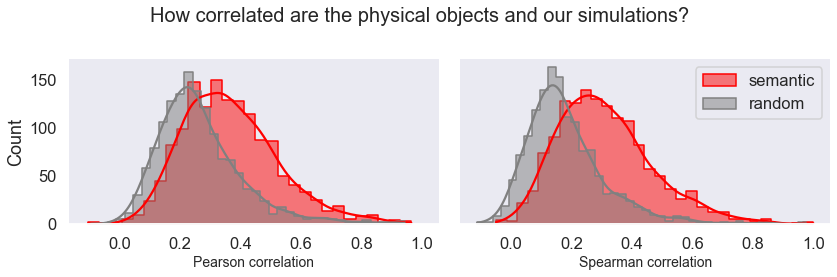

In [939]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
fig.suptitle('How correlated are the physical objects and our simulations?', fontsize=20)
sns.histplot(sem_corrs, label='semantic', element="step", color='red', kde=True, ax=axs[0])
sns.histplot(rand_corrs, label='random', element="step", color='grey', kde=True, ax=axs[0]);
sns.histplot(sem_spcorrs, label='semantic', element="step", color='red', kde=True, ax=axs[1])
sns.histplot(rand_spcorrs, label='random', element="step", color='grey', kde=True, ax=axs[1])
axs[0].set_xlabel('Pearson correlation', fontsize=14)
axs[1].set_xlabel('Spearman correlation', fontsize=14)
sns.despine(left=True)
plt.legend()
fig.tight_layout()

In [998]:
rsqs.groupby('cond').rsq.mean()

cond
random      0.091164
semantic    0.159315
Name: rsq, dtype: float64

In [984]:
stats.ttest_ind(sem_corrs, rand_corrs, equal_var=False)

Ttest_indResult(statistic=17.78546026625494, pvalue=3.406661411508523e-67)

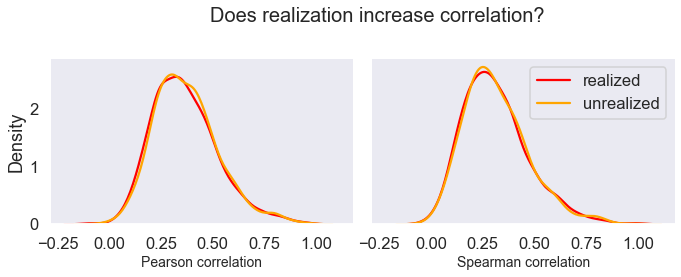

In [1038]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
fig.suptitle('Does realization increase correlation?', fontsize=20, x=0.56)
sns.kdeplot(sem_corrs, label='realized', color='red', ax=axs[0])
sns.kdeplot(sem_unreal_corrs, label='unrealized', color='orange', ax=axs[0])
sns.kdeplot(sem_spcorrs, label='realized', color='red', ax=axs[1])
sns.kdeplot(sem_unreal_spcorrs, label='unrealized', color='orange', ax=axs[1])
axs[0].set_xlabel('Pearson correlation', fontsize=14)
axs[1].set_xlabel('Spearman correlation', fontsize=14)
sns.despine(left=True)
plt.legend()
fig.tight_layout()

In [14]:
CI = np.percentile(np.square(sem_corrs), [5, 95])
print(f'The realized semantic embedding explains on average {np.square(sem_corrs).mean()*100:.2f}% of \
variability in the real object locations. 90% of values fall between {CI[0]*100:.2f}% and {CI[1]*100:.2f}%.')
CI = np.percentile(np.square(rand_corrs), [5, 95])
print(f'A random embedding explains on average {np.square(rand_corrs).mean()*100:.2f}% of \
variability in the real object locations. 90% of values fall between {CI[0]*100:.2f}% and {CI[1]*100:.2f}%.')

The realized semantic embedding explains on average 15.93% of variability in the real object locations. 90% of values fall between 2.05% and 43.11%.
A random embedding explains on average 8.87% of variability in the real object locations. 90% of values fall between 0.70% and 26.71%.


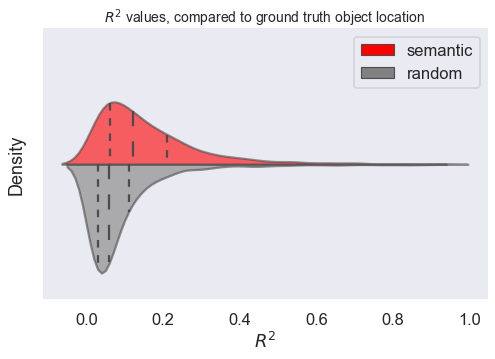

In [941]:
a = pd.DataFrame(np.square(sem_corrs), columns=['rsq'])
b = pd.DataFrame(np.square(rand_corrs), columns=['rsq'])
a['cond'] = 'semantic'
b['cond'] = 'random'
rsqs = pd.concat([a,b]).reset_index(drop=True)
rsqs['all'] = ''

fig, ax = plt.subplots(figsize=(8,5))
sns.violinplot(data=rsqs, x='rsq', y='all', 
               split=True, hue='cond', inner='quartile', 
               palette=['red', 'grey'], legend="brief", ax=ax, saturation=1)
plt.legend(title='');
plt.title('$R^2$ values, compared to ground truth object location', fontsize=14)
plt.xlabel('$R^2$')
plt.ylabel('Density')
ax.collections[0].set_alpha(0.6)
ax.collections[1].set_alpha(0.6)
plt.show()

### Heatmap analysis

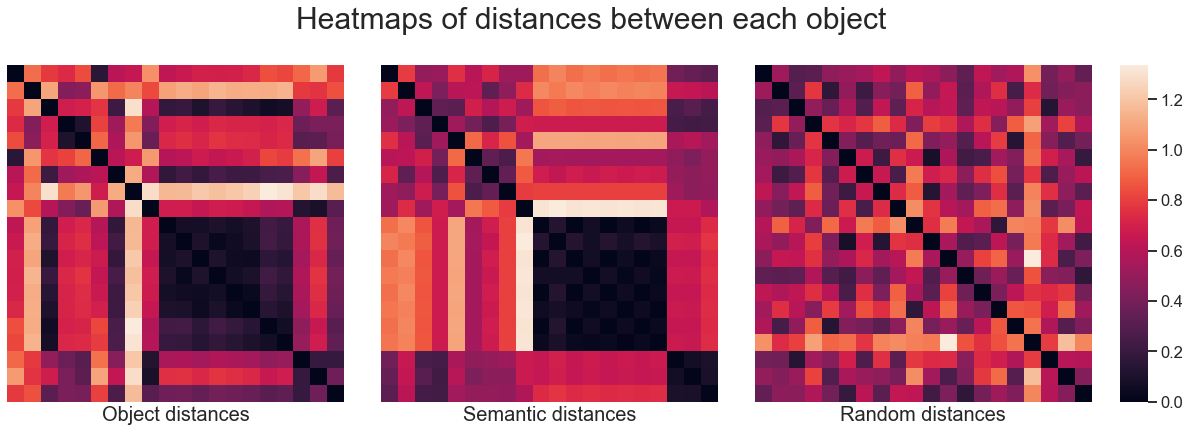

In [945]:
samp_idx = np.random.choice(semantic_object_df.image_index.unique())
samp_df_1 = semantic_object_df[semantic_object_df.image_index == samp_idx]#644
samp_df_2 = object_df[object_df.image_index == samp_idx]
sem_euc = euclidean_distances(samp_df_1[['x', 'y', 'z']])
obj_euc = euclidean_distances(samp_df_2[['x_dist', 'y_dist', 'depth']])
rand_euc = euclidean_distances(np.random.random((obj_euc.shape[0], 3)))

fig,axs = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize=(17,6))
axs[0].get_shared_y_axes().join(axs[1],axs[2])

g = sns.heatmap(obj_euc, square=True, cbar=False, ax=axs[0])
g.set_ylabel('')
g.set_xlabel('Object distances', fontsize=20)
g.set_xticks([])
g.set_yticks([])
g = sns.heatmap(sem_euc, square=True, cbar=False, ax=axs[1])
g.set_ylabel('')
g.set_xlabel('Semantic distances', fontsize=20)
g.set_yticks([])
g.set_xticks([])
g = sns.heatmap(rand_euc, square=True, cbar_ax=axs[3], ax=axs[2])
g.set_ylabel('')
g.set_xlabel('Random distances', fontsize=20)
g.set_yticks([])
g.set_xticks([])

fig.suptitle('Heatmaps of distances between each object', fontsize=30)
fig.tight_layout()
plt.show()

In [216]:
real_emb_corrs = []
for i in tqdm(semantic_object_df.image_index.unique()):
    samp_df_1 = semantic_object_df[semantic_object_df.image_index == i]
    sem_real_euc = euclidean_distances(samp_df_1[['x', 'y', 'z']]).flatten()
    sem_emb_euc = semantic_dists(samp_df_1).flatten()
    
    sem_corr = np.corrcoef(sem_real_euc, sem_emb_euc)[0][1]
    real_emb_corrs.append(sem_corr)

100%|██████████████████████████████████████████████████████████████████████████████| 1445/1445 [04:10<00:00,  5.76it/s]


Mean correlation: 0.92


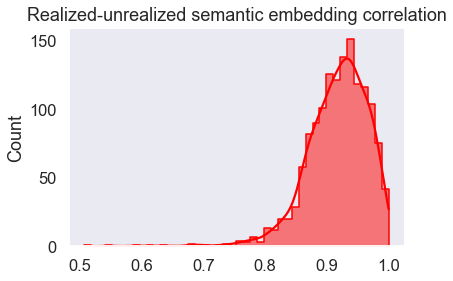

In [958]:
plt.figure(figsize=(6,4))
plt.title('Realized-unrealized semantic embedding correlation', y=1.01)
sns.histplot(real_emb_corrs, element="step", color='red', kde=True)
print(f'Mean correlation: {np.mean(real_emb_corrs):0.2f}')

In [777]:
realization_divergence_l2 = []
realization_divergence_l1 = []
realization_divergence_cos = []
realization_divergence_mse = []
for i in tqdm(range(1449)):
    samp_df_1 = semantic_object_df[semantic_object_df.image_index == i]
    if samp_df_1.shape[0] == 0:
        continue

    sem_euc = euclidean_distances(samp_df_1[['x', 'y', 'z']])
    sem_unreal_dist = semantic_dists(samp_df_1)
    div = np.square(sem_euc - sem_unreal_dist).sum()
    realization_divergence_l2.append(div)
    realization_divergence_mse.append(div / sem_unreal_dist.size)
    div = np.abs(sem_euc - sem_unreal_dist).sum()
    realization_divergence_l1.append(div)
    div = distance.cosine(sem_euc.flatten(), sem_unreal_dist.flatten())
    realization_divergence_cos.append(div)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1449/1449 [03:20<00:00,  7.21it/s]


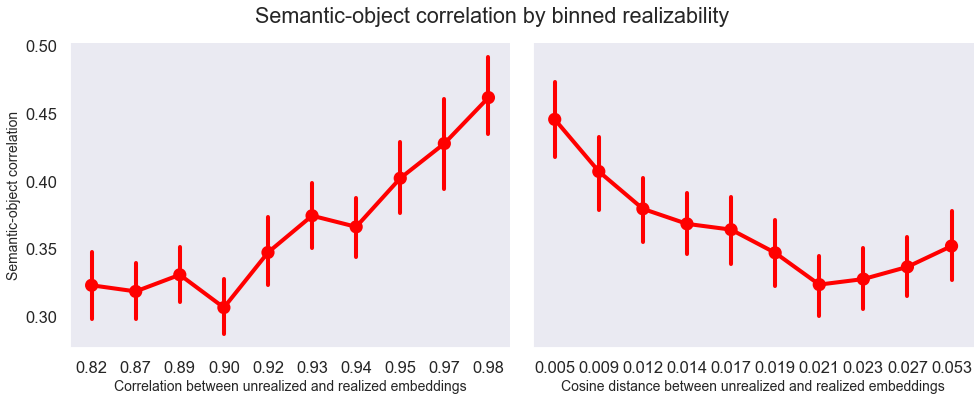

In [952]:
bins = np.percentile(np.array(real_emb_corrs), np.linspace(0, 90, 10))
bins = np.append(bins, 1)

realization_loss_r = pd.DataFrame(np.array([sem_corrs, real_emb_corrs]).T, 
                                columns=['semantic-object correlation', 'realization correlation'])
cuts = pd.cut(realization_loss_r['realization correlation'], bins, labels=range(10))
realization_loss_r['bins'] = cuts

fig, axs = plt.subplots(1, 2, figsize=(14,6), sharey=True)
sns.pointplot(data=realization_loss_r, x='bins', y='semantic-object correlation', color='red', ax=axs[0])

bin_vals = realization_loss_r.groupby('bins')['realization correlation'].mean()
axs[0].set_xticklabels([f'{i:0.2f}' for i in bin_vals]);
axs[0].set_xlabel('Correlation between unrealized and realized embeddings', fontsize=14)
axs[0].set_ylabel('Semantic-object correlation', fontsize=14)

bins = np.percentile(np.array(realization_divergence_cos), np.linspace(0, 90, 10))
bins = np.append(bins, np.array(realization_divergence_cos).max())
realization_divergence_loss = pd.DataFrame(np.array([sem_corrs, realization_divergence_cos]).T, 
                                columns=['semantic-object correlation', 'realization divergence'])
cuts = pd.cut(realization_divergence_loss['realization divergence'], bins, labels=range(10))
realization_divergence_loss['bins'] = cuts

sns.pointplot(data=realization_divergence_loss, x='bins', y='semantic-object correlation', color='red', ax=axs[1])

bin_vals = realization_divergence_loss.groupby('bins')['realization divergence'].mean()

axs[1].set_xticklabels([f'{val:0.3f}' for val in bin_vals]);
axs[1].set_xlabel('Cosine distance between unrealized and realized embeddings', fontsize=14)
axs[1].set_ylabel('')

fig.suptitle('Semantic-object correlation by binned realizability', y=0.94)
fig.tight_layout()

### What scenes are well correlated? What scenes are poorly correlated?

In [510]:
mid = obj_sem_corrs.shape[0] // 2
df_used = df.scene_type.value_counts()[df.scene_type.value_counts() > 40]
df_used = df[df.scene_type.isin(df_used.index)]
obj_sem_corrs = np.array(sem_corrs)
low_idx = np.argpartition(obj_sem_corrs, mid)[:mid]
high_idx = np.argpartition(obj_sem_corrs, -mid)[-mid:]

df_low_corr = df_used[df_used.index.isin(low_idx)]
df_high_corr = df_used[df_used.index.isin(high_idx)]

df_low_corr = (df_low_corr.scene_type.value_counts() / df_used.scene_type.value_counts()).dropna()
df_high_corr = (df_high_corr.scene_type.value_counts() / df_used.scene_type.value_counts()).dropna()

df_low_corr = df_low_corr.sort_values(ascending=False)
df_high_corr = df_high_corr.sort_values(ascending=False)

corr_df = pd.DataFrame([df_low_corr, df_high_corr], index=['low', 'high']).T
corr_df = corr_df.rename_axis('scene').reset_index()
corr_df = corr_df.sort_values(by='high', ascending=False)
corr_df = corr_df.melt(id_vars='scene', value_vars=['low', 'high'], var_name='correlation', value_name='corr')

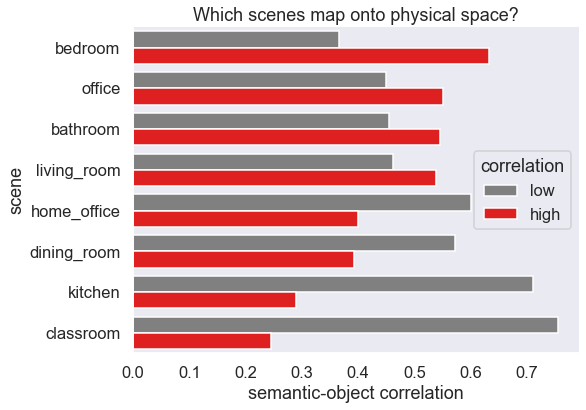

In [959]:
plt.figure(figsize=(8,6))
sns.barplot(data=corr_df, y='scene', x='corr', hue='correlation', palette=['grey', 'red']);
plt.xlabel('semantic-object correlation')
plt.ylabel('scene')
plt.title('Which scenes map onto physical space?');